#Define all path in this file

In [2]:
#name of data folder: Tên thư mục chứa folder data, trong đó nên có folder train và validation
DATA_DIR_NAME = "dataset"

# 1. Install Dependencies and Setup

In [3]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [15]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [16]:
import cv2
import imghdr

In [31]:
data_dir = "Forencis/Dataset/train" #os.path.join(PROJECT_PATH, DATA_DIR_NAME)
data_dir

'Forencis/Dataset/train'

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [32]:
#Kích thước sample, image_dataset_from_directory sẽ nén ảnh về size này để đúng 1 chuẩn
data = tf.keras.utils.image_dataset_from_directory( data_dir)

Found 16002 files belonging to 2 classes.


In [33]:
# Get the class names
class_names = data.class_names

# Print the class names
print(class_names)

['fake', 'real']


In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
batch = data_iterator.next()

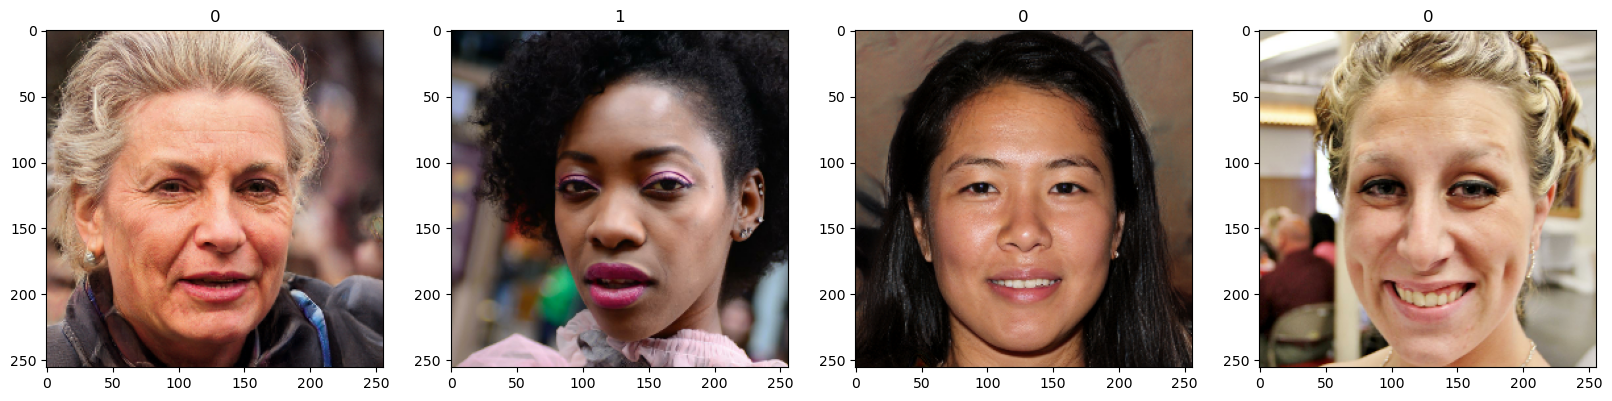

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][12:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [21]:
data = data.map(lambda x,y: (x/255, y))

In [22]:
data.as_numpy_iterator().next()

(array([[[[9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          [9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          [9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          ...,
          [9.96078432e-01, 9.68627453e-01, 9.05882359e-01],
          [9.96078432e-01, 9.68627453e-01, 9.05882359e-01],
          [9.96078432e-01, 9.68627453e-01, 9.05882359e-01]],
 
         [[9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          [9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          [9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          ...,
          [9.96078432e-01, 9.68627453e-01, 9.05882359e-01],
          [9.96078432e-01, 9.68627453e-01, 9.05882359e-01],
          [9.96078432e-01, 9.68627453e-01, 9.05882359e-01]],
 
         [[9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          [9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          [9.96078432e-01, 9.80392158e-01, 9.33333337e-01],
          ...,
          [9.96078432e-01, 9.68627453e-01, 9.0588

# 5. Split Data

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [24]:
train_size

350

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [32]:
logdir='logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [44]:
hist = model.fit(train, epochs=9, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/9
350/350 [==============================] - 346s 970ms/step - loss: 0.5232 - accuracy: 0.7429 - val_loss: 0.4838 - val_accuracy: 0.7703
Epoch 2/9
350/350 [==============================] - 342s 973ms/step - loss: 0.4105 - accuracy: 0.8101 - val_loss: 0.4435 - val_accuracy: 0.8016
Epoch 3/9
350/350 [==============================] - 304s 864ms/step - loss: 0.2961 - accuracy: 0.8727 - val_loss: 0.4566 - val_accuracy: 0.8075
Epoch 4/9
350/350 [==============================] - 317s 901ms/step - loss: 0.1919 - accuracy: 0.9237 - val_loss: 0.5637 - val_accuracy: 0.7934
Epoch 5/9
350/350 [==============================] - 314s 893ms/step - loss: 0.1088 - accuracy: 0.9583 - val_loss: 0.7496 - val_accuracy: 0.7894
Epoch 6/9
350/350 [==============================] - 332s 944ms/step - loss: 0.0769 - accuracy: 0.9720 - val_loss: 0.7710 - val_accuracy: 0.8125
Epoch 7/9
350/350 [==============================] - 345s 981ms/step - loss: 0.0489 - accuracy: 0.9832 - val_loss: 0.8759 - val_ac

# 8. Plot Performance

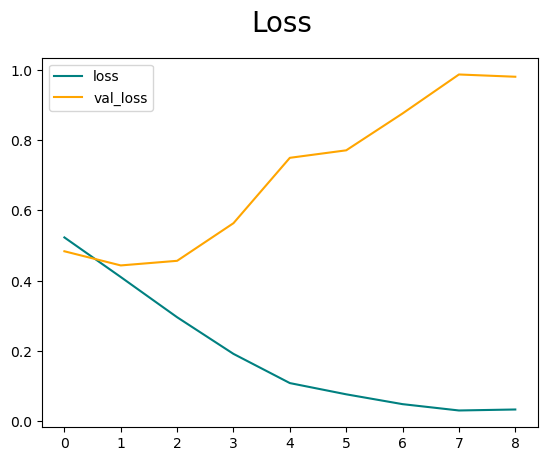

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Overfitting

=> TỪ epoch tứ 2 model bắt đầu có dấu hiệu bị overfitting => Early Stopping Method sẽ được thêm vào

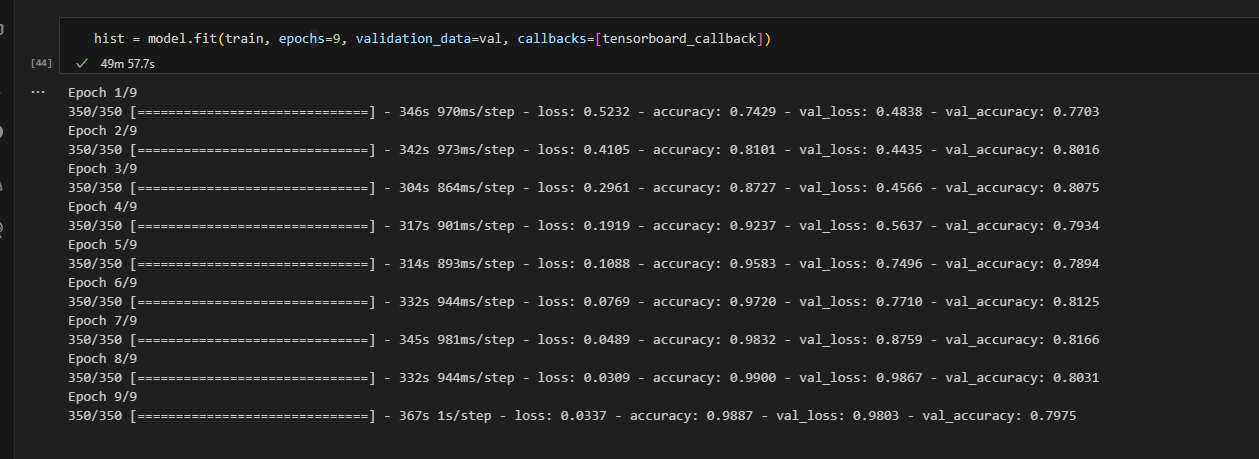

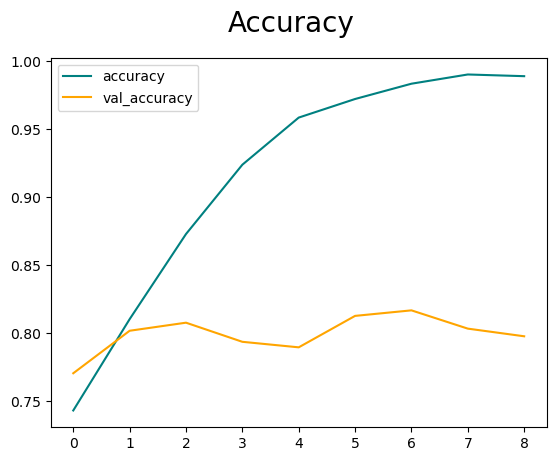

In [46]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [47]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [49]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 134ms/step


In [50]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8328125, shape=(), dtype=float32) tf.Tensor(0.6637609, shape=(), dtype=float32) tf.Tensor(0.764375, shape=(), dtype=float32)


# 10. Test

In [1]:
import cv2 as cv

In [3]:
import matplotlib.pyplot as plt

In [45]:
def OutputLabel(yHat):
    # Get the predicted class index (0 or 1 in binary classification)
    predicted_class_index = int(yhat > 0.5)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Print the result
    print(f'Predicted class is {predicted_class_name}')

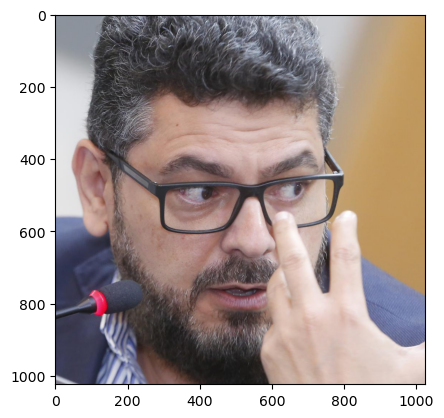

In [41]:
import matplotlib.image as mpimg

image = mpimg.imread("Forencis/Dataset/validation/real/8001.jpg")
plt.imshow(image)
plt.show()

In [25]:
import numpy as np

In [42]:
resize = tf.image.resize(image, (256, 256))
yhat = new_model.predict(np.expand_dims(resize / 255, 0))

1/1 [==============================] - 0s 31ms/step


In [43]:
yhat

array([[0.9996751]], dtype=float32)

In [47]:
OutputLabel(yhat)

Predicted class is real


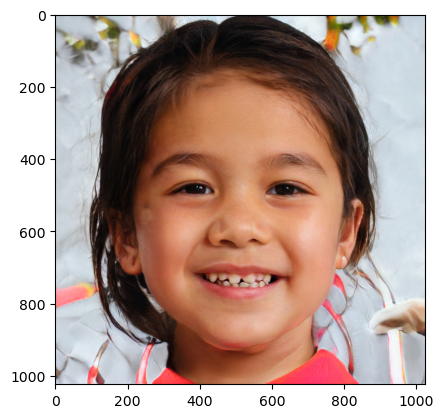

In [49]:
import matplotlib.image as mpimg

image = mpimg.imread("Forencis/Dataset/validation/fake/8001.jpg")
plt.imshow(image)
plt.show()

In [50]:
resize = tf.image.resize(image, (256, 256))
yhat = new_model.predict(np.expand_dims(resize / 255, 0))
OutputLabel(yhat)

1/1 [==============================] - 0s 29ms/step
Predicted class is fake


# 11. Save the Model

In [21]:
from tensorflow.keras.models import load_model

In [58]:
model.save(os.path.join('models','imageclassifier.h5'))

In [22]:
new_model = load_model('models\imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))